<a href="https://colab.research.google.com/github/KaifAhmad1/code-test/blob/main/Llumo_AI_Assignment_Mohd_Kaif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Fine Tuning Meta's Llama 3.2B Model on Meta Review Summarization Task**

In [ ]:
!pip install -qU transformers datasets evaluate rouge_score trl peft bitsandbytes accelerate xformer

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
import evaluate
import matplotlib.pyplot as plt
from accelerate import Accelerator
from huggingface_hub import notebook_login
from transformers import pipeline
import os

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Enable xformers for optimized attention
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Initialize accelerator
accelerator = Accelerator()

In [ ]:
# Load and explore the dataset
dataset = load_dataset("zqz979/meta-review")
print(f"Dataset size: {len(dataset['train'])} train, {len(dataset['validation'])} validation, {len(dataset['test'])} test")

print("\nSample Meta-Review:")
print(dataset['train'][0]['Input'][:500] + "...")
print("\nSample Summary:")
print(dataset['train'][0]['Output'])

Dataset size: 7692 train, 1648 validation, 1649 test

Sample Meta-Review:
In this paper, the author investigates how to utilize large-scale human video to train dexterous robot manipulation skills. To leverage the information from the Internet videos, the author proposes a handful of techniques to pre-process the video data to extract the action information. Then the network is trained on the extracted hand data and deployed to the real robot with some human demonstration collected by teleoperation for fine-tuning. Experiments show that the proposed pipeline can solve...

Sample Summary:
This paper studies how to learn dexterous manipulation from human videos.    In the initial review, the reviewer appreciated the direction and real-world experiment but also raised  concerns about the need of special sensor for tracking. During rebuttal, the authors effectively addressed this concern by providing additional experiment results, and reviewers were satisfied with the response.  AC would l

In [33]:
# Load tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Configure quantization for faster training and lower memory usage
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16  # Use bf16 for computation
)

# Load model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

# Enable gradient checkpointing and disable caching for memory efficiency
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [34]:
# Improved prompt for summarization
def generate_summary_prompt(meta_review):
    return f"""As an AI trained to summarize meta-reviews of academic papers, your task is to provide a concise and informative summary that captures the key points of the following meta-review. Focus on these aspects:

1. Overall assessment: The general consensus on the paper's quality and contribution.
2. Strengths: The main positive points highlighted by reviewers.
3. Weaknesses: Primary concerns or criticisms raised.
4. Recommendations: Any suggestions for improvement or future work.
5. Decision: The final verdict (e.g., accept, reject, revise).

Ensure your summary is objective, clear, and captures the essence of the meta-review without specific details about individual reviewers' comments. Aim for a length of 3-5 sentences.

Meta-review:
{meta_review}

Summary:"""

# Preprocess Data
def preprocess_function(examples):
    inputs = [generate_summary_prompt(review) for review in examples["Input"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(examples["Output"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = dataset['train'].map(preprocess_function, batched=True, remove_columns=dataset['train'].column_names, num_proc=4)
tokenized_eval = dataset['validation'].map(preprocess_function, batched=True, remove_columns=dataset['validation'].column_names, num_proc=4)

In [38]:
# Define LoRA Configuration with smaller rank for faster training
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",]
)

In [43]:
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=1000,
    learning_rate=2e-4,
    weight_decay=0.001,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    gradient_checkpointing=True
)

In [44]:
# Define evaluation metric
rouge = evaluate.load('rouge')

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, use_stemmer=True)
    return {
        'rouge1': rouge_output['rouge1'].mid.fmeasure,
        'rouge2': rouge_output['rouge2'].mid.fmeasure,
        'rougeL': rouge_output['rougeL'].mid.fmeasure,
    }

# Set up trainer
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    peft_config=lora_config,
    dataset_text_field="Input",
    max_seq_length=256,
    compute_metrics=compute_metrics,
)

# Train the model
print("Starting fast model training...")
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Starting fast model training...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
1000,1.962000
2000,1.844600
3000,1.764600
4000,1.685300
5000,1.610200
6000,1.543800
7000,1.482800
8000,1.441900
9000,1.414700


TrainOutput(global_step=9620, training_loss=1.6236451083558017, metrics={'train_runtime': 5204.2254, 'train_samples_per_second': 14.78, 'train_steps_per_second': 1.848, 'total_flos': 2.3128451309371392e+17, 'train_loss': 1.6236451083558017, 'epoch': 10.0})

In [45]:
# Save the fine-tuned model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("Fine-tuned model saved.")

Fine-tuned model saved.


In [46]:
# Generate Summaries
summarizer = pipeline("text-generation", model="./fine_tuned_model", tokenizer=tokenizer, device=accelerator.device)

def generate_summary_with_model(meta_review):
    prompt = generate_summary_prompt(meta_review)
    response = summarizer(prompt, max_new_tokens=150, do_sample=True, top_p=0.9, temperature=0.7)
    return response[0]["generated_text"].split("Summary:")[-1].strip()

# Evaluate Model Performance
# Use a subset of the test set for evaluation
test_subset = dataset["test"].shuffle(seed=42).select(range(500))
tokenized_test = test_subset.map(preprocess_function, batched=True, remove_columns=test_subset.column_names, num_proc=4)

test_results = trainer.evaluate(tokenized_test)

print("\nTest Set Evaluation Results:")
print(f"Loss: {test_results['eval_loss']:.4f}")
print(f"ROUGE-1: {test_results['eval_rouge1']:.4f}")
print(f"ROUGE-2: {test_results['eval_rouge2']:.4f}")
print(f"ROUGE-L: {test_results['eval_rougeL']:.4f}")

# Generate and Compare Summaries
num_samples = 5
for i in range(num_samples):
    test_meta_review = test_subset[i]["Input"]
    generated_summary = generate_summary_with_model(test_meta_review)
    actual_summary = test_subset[i]["Output"]

    print(f"\nSample {i+1}:")
    print("Generated Summary:", generated_summary)
    print("Actual Summary:", actual_summary)

    # Compute ROUGE scores for this sample
    rouge_scores = rouge.compute(predictions=[generated_summary], references=[actual_summary], use_stemmer=True)
    print(f"ROUGE-1: {rouge_scores['rouge1'].mid.fmeasure:.4f}")
    print(f"ROUGE-2: {rouge_scores['rouge2'].mid.fmeasure:.4f}")
    print(f"ROUGE-L: {rouge_scores['rougeL'].mid.fmeasure:.4f}")

OSError: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

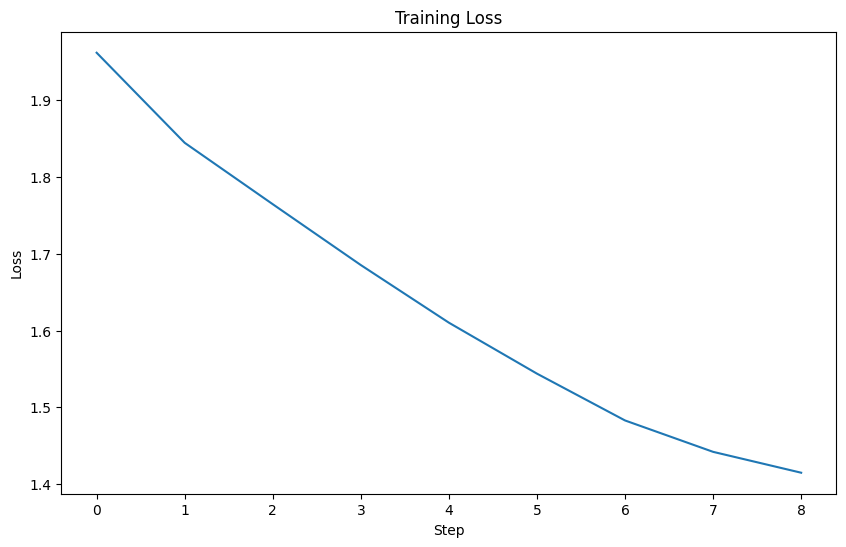

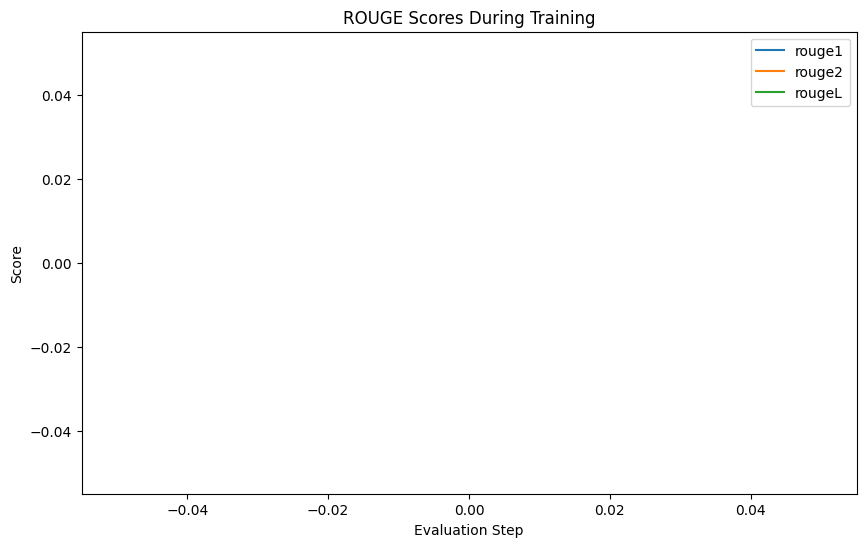

In [47]:
# Visualize Training Progress
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot([log['loss'] for log in trainer.state.log_history if 'loss' in log])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

# Plot ROUGE scores
plt.figure(figsize=(10, 6))
for metric in ['rouge1', 'rouge2', 'rougeL']:
    plt.plot([log[f'eval_{metric}'] for log in trainer.state.log_history if f'eval_{metric}' in log], label=metric)
plt.title('ROUGE Scores During Training')
plt.xlabel('Evaluation Step')
plt.ylabel('Score')
plt.legend()
plt.show()